In [1]:
import plot
from shap.maskers import Independent
import shap
from matplotlib import pyplot as plt
from sklearn.utils import resample, shuffle
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [11]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff = pickle.load(f)

In [4]:
try:
    with open('shapvalues.log_odds.pickle', 'rb') as f:
        shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, is_finite, is_outlier, is_normal, overall_importance, feature_order, shap_values_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


Now we define the difference functions to be explained:

In [3]:
log_proba_add = lambda y1, y2: y1 + np.log1p(np.exp(y2 - y1))
log_proba_complement = lambda y: np.log1p(-np.exp(y))
log_proba_to_log_odds = lambda x: x - log_proba_complement(x)
merge_log_proba_diff_c1_pos = lambda y1, y2: y1[:, 1] + y2[:, 0]
predict_log_odds_diff_a_pos = lambda X: log_proba_to_log_odds(merge_log_proba_diff_c1_pos(clf_a.predict_log_proba(X), clf_b.predict_log_proba(X)))
predict_log_odds_diff_b_pos = lambda X: log_proba_to_log_odds(merge_log_proba_diff_c1_pos(clf_b.predict_log_proba(X), clf_a.predict_log_proba(X)))

In [4]:
merge_log_proba_diff = lambda y1, y2: log_proba_add(merge_log_proba_diff_c1_pos(y1, y2), merge_log_proba_diff_c1_pos(y2, y1))
predict_log_odds_diff = lambda X: log_proba_to_log_odds(merge_log_proba_diff(clf_a.predict_log_proba(X), clf_b.predict_log_proba(X)))

And now we calculate SHAP values for each merge function:

In [5]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    shap_values.display_data = display_data
    return shap_values

shap_values_diff = explain(predict_log_odds_diff)
shap_values_diff_a_pos = explain(predict_log_odds_diff_a_pos)
shap_values_diff_b_pos = explain(predict_log_odds_diff_b_pos)

shap_values_diff_a_vs_b_pos = shap_values_diff_b_pos - shap_values_diff_a_pos
shap_values_diff_a_vs_b_pos.data = shap_values_diff_a_pos.data
shap_values_diff_a_vs_b_pos.display_data = shap_values_diff_a_pos.display_data

is_finite = np.all(np.isfinite(shap_values_diff.values), axis=1)
is_outlier = np.any(shap_values_diff.abs.values > 12, axis=1)
is_normal = is_finite & ~is_outlier

overall_importance = shap_values_diff[is_normal].abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

with open(f'shapvalues.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, is_finite, is_outlier, is_normal, overall_importance, feature_order, shap_values_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer:  20%|##        | 6524/32561 [07:28<30:35, 14.19it/s]  divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
Permutation explainer: 32562it [31:54, 16.94it/s]                            
Permutation explainer: 32562it [25:05, 21.48it/s]                           
Permutation explainer: 32562it [25:11, 21.39it/s]                            


CPU times: user 2h 14min 53s, sys: 12min 15s, total: 2h 27min 8s
Wall time: 1h 22min 21s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

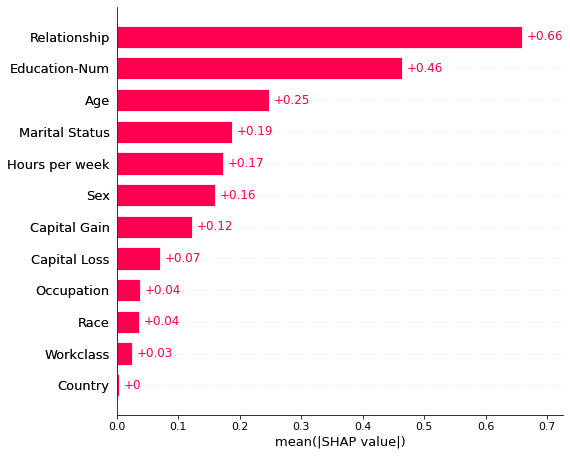

In [6]:
shap.plots.bar(overall_importance, max_display=n_features)

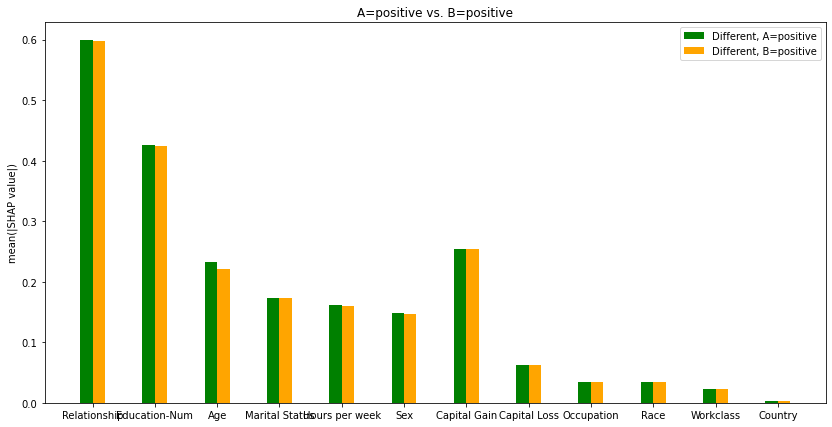

In [7]:
labels = feature_names[feature_order]

x = np.arange(n_features)
width = 0.2

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, shap_values_diff_a_pos.abs.mean(0)[feature_order].values, width, label='Different, A=positive', color='green')
rects2 = ax.bar(x + width/2, shap_values_diff_b_pos.abs.mean(0)[feature_order].values, width, label='Different, B=positive', color='orange')
ax.set_ylabel('mean(|SHAP value|)')
ax.set_title('A=positive vs. B=positive')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

TODO: build own plots, where all sets of instances are in one plot, with different colors per set and a color range from low to high feature value as well

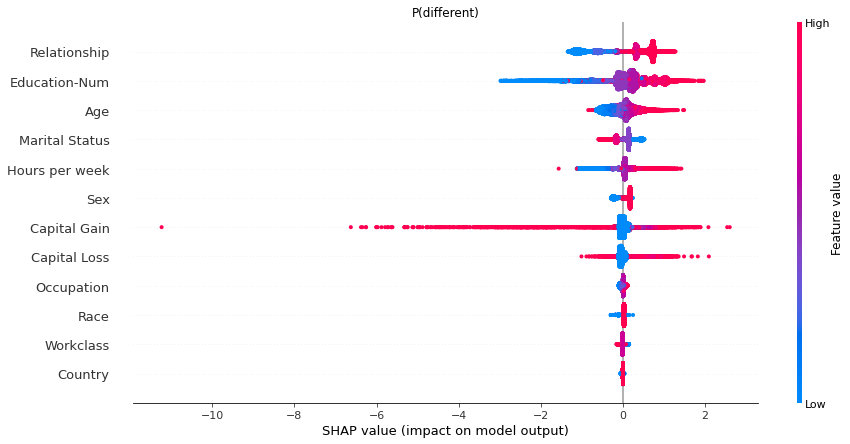

In [8]:
plot.shap_beeswarm(shap_values_diff[is_normal], 'P(different)', order=feature_order, max_display=n_features)

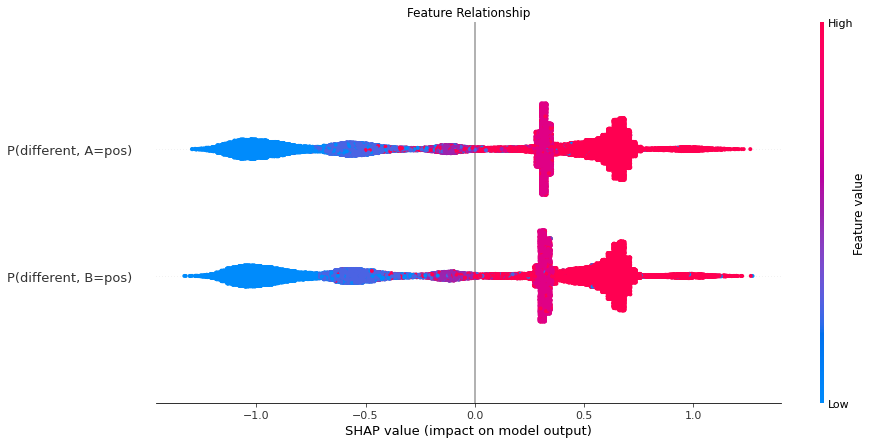

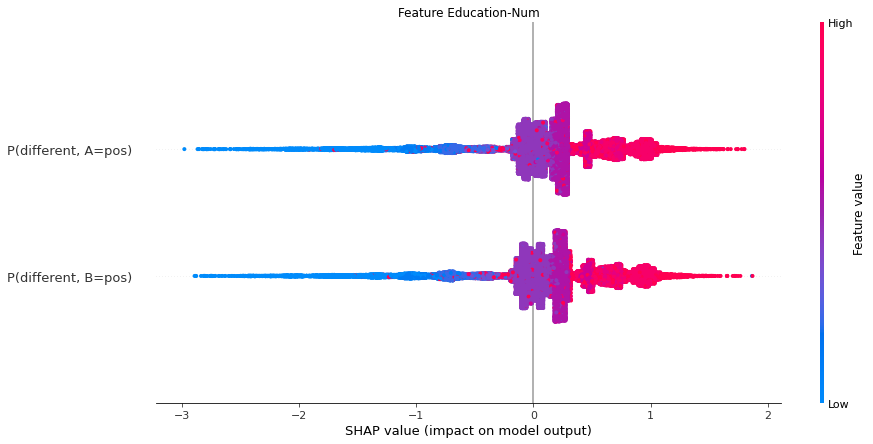

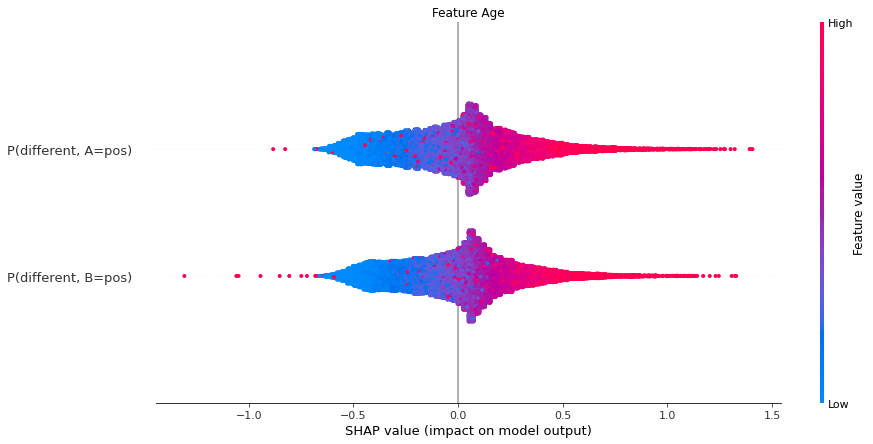

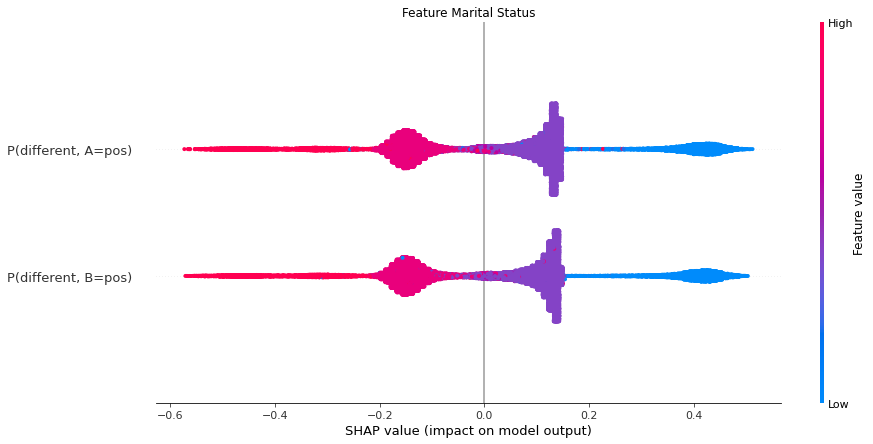

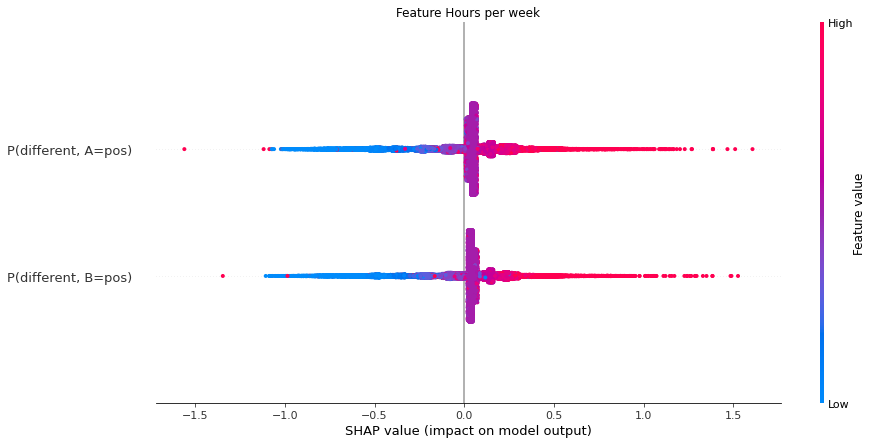

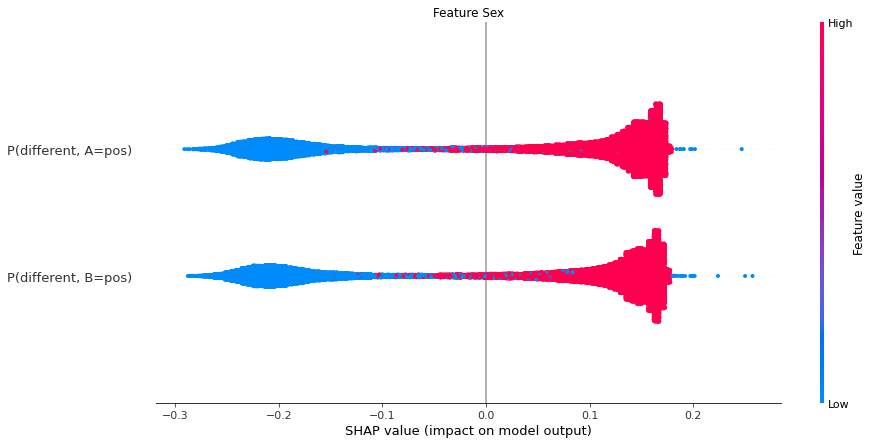

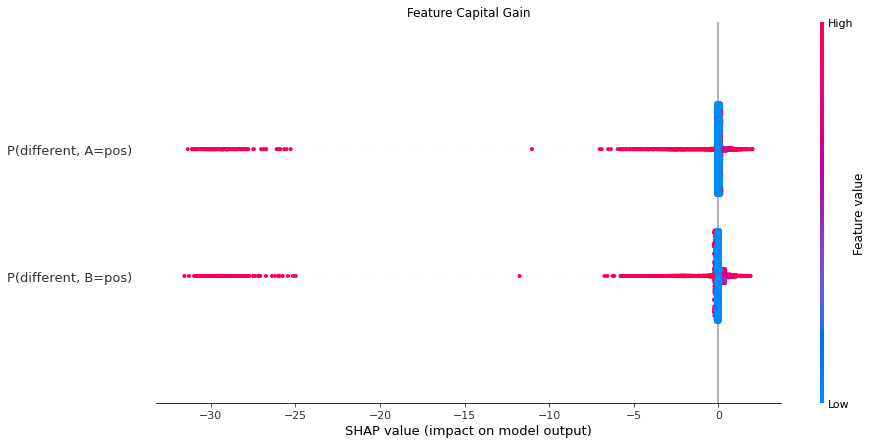

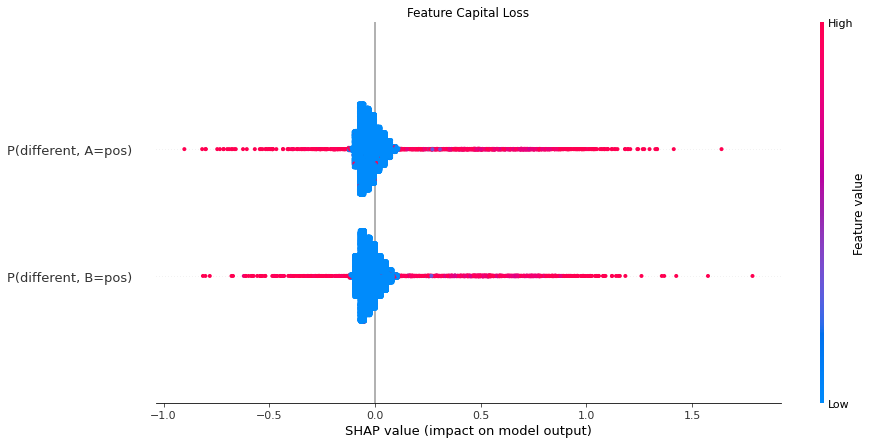

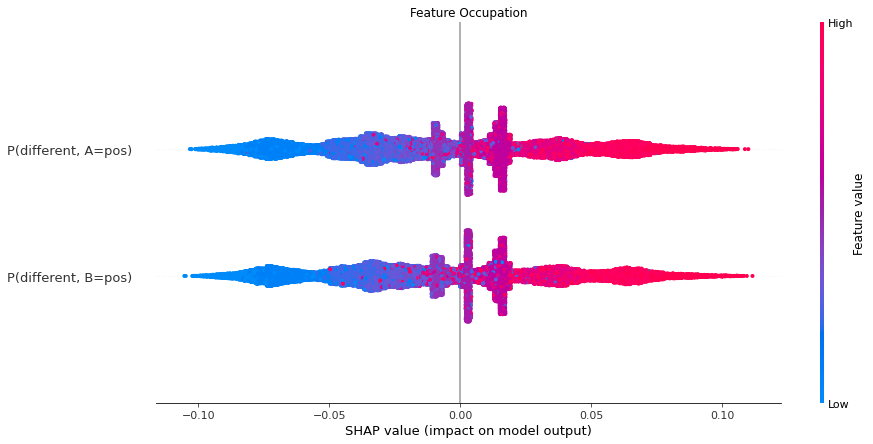

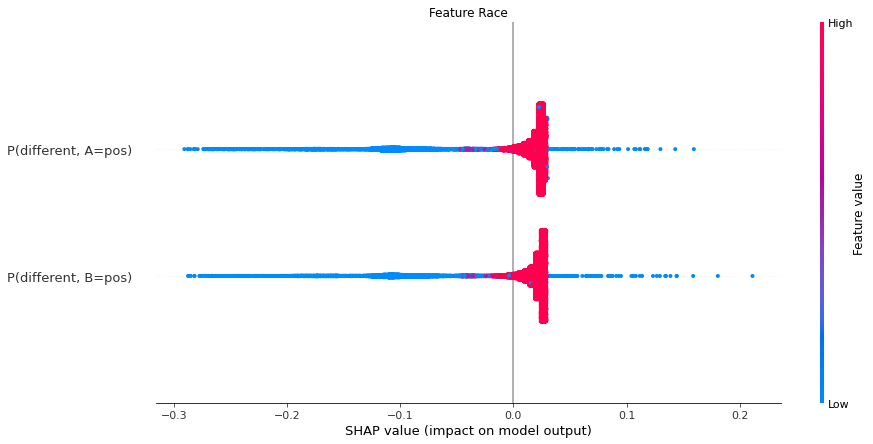

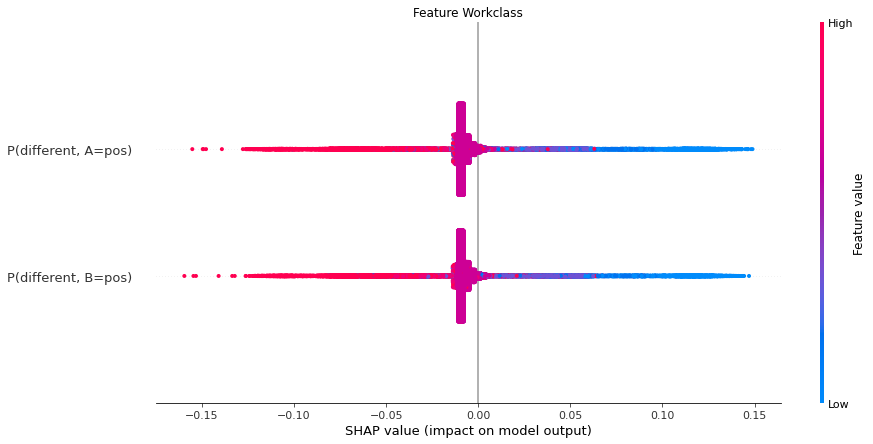

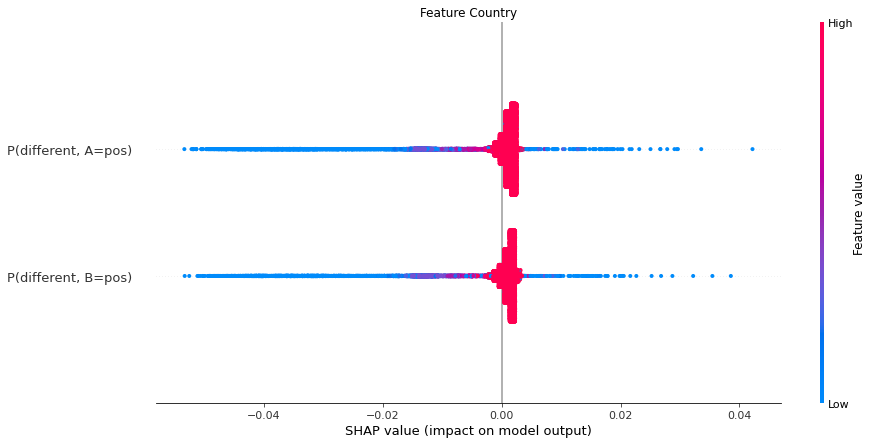

In [9]:
for feature in feature_names[feature_order]:
    a_feature = shap_values_diff_a_pos[:, feature]
    b_feature = shap_values_diff_b_pos[:, feature]
    values = np.array([a_feature.values, b_feature.values]).T
    base_values = np.array([a_feature.base_values, b_feature.base_values]).T
    data = np.array([a_feature.data, b_feature.data]).T
    display_data = np.array([a_feature.display_data, b_feature.display_data]).T
    explanation = shap.Explanation(values, base_values, data, display_data, feature_names=['P(different, A=pos)', 'P(different, B=pos)'])
    plot.shap_beeswarm(explanation, 'Feature ' + feature)

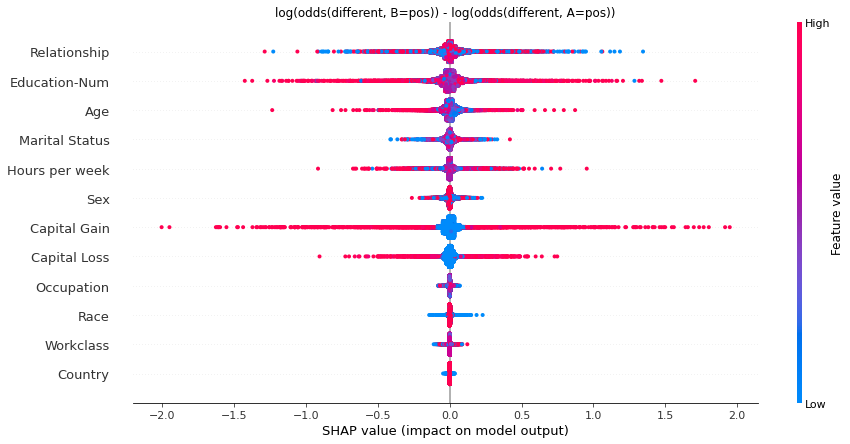

In [11]:
plot.shap_beeswarm(shap_values_diff_a_vs_b_pos, 'log(odds(different, B=pos)) - log(odds(different, A=pos))', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

- TODO: lm through points drawn; print parameters in title

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


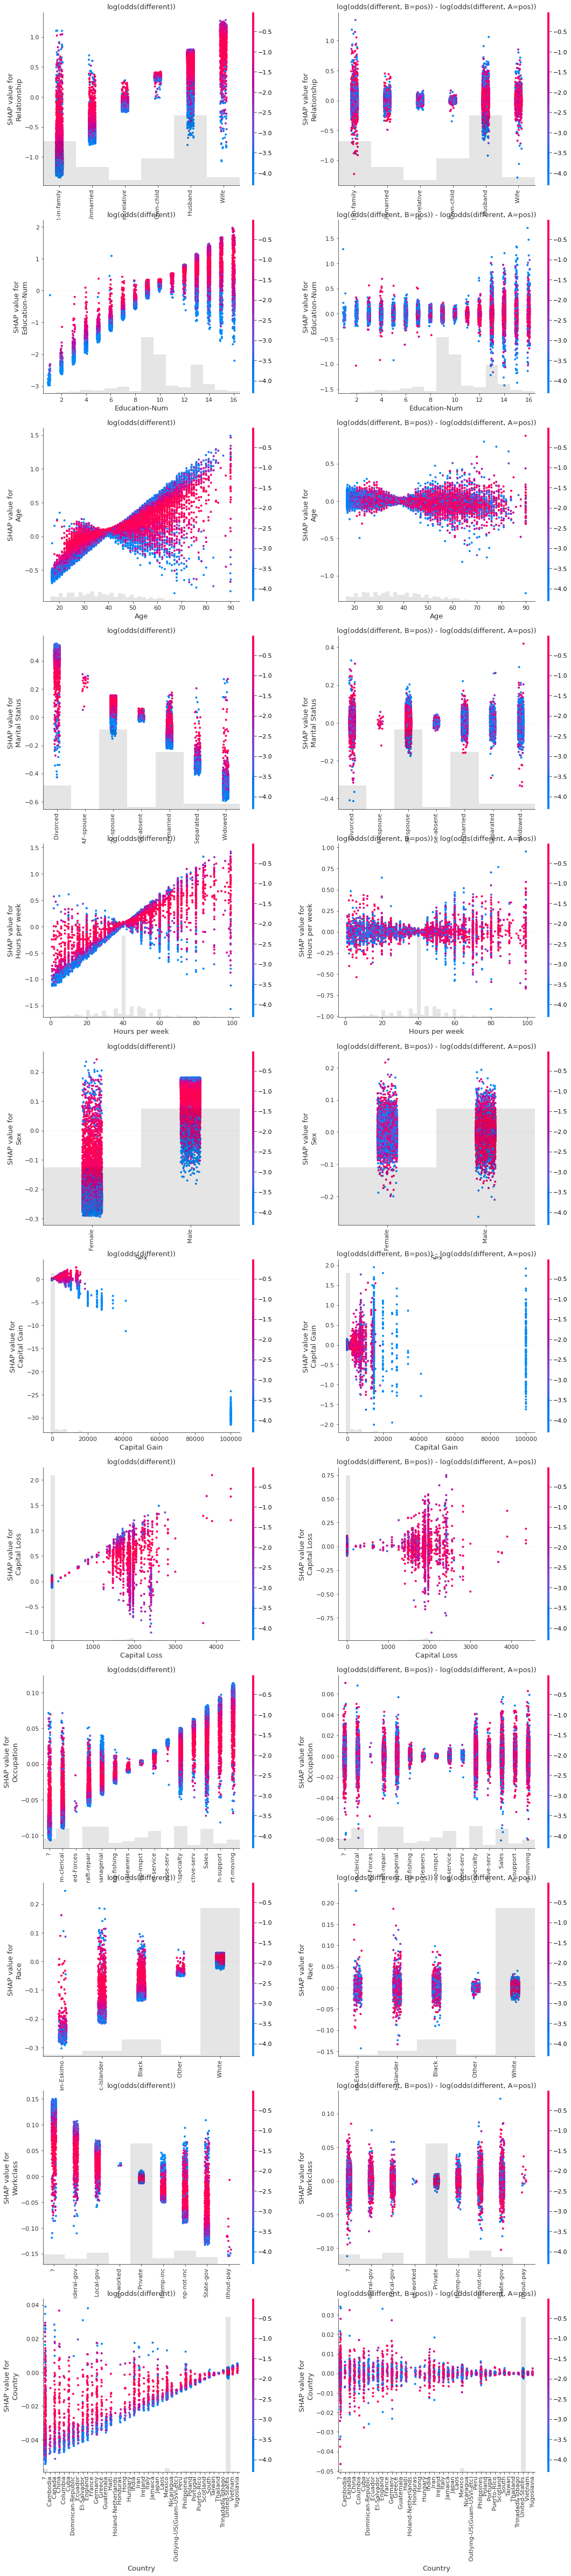

In [12]:
n_columns = 2
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=None)
    shap.plots.scatter(shap_values_diff[:, feature], title='log(odds(different))', ax=ax1, color=log_odds_diff, show=False)
    shap.plots.scatter(shap_values_diff_a_vs_b_pos[:, feature], title='log(odds(different, B=pos)) - log(odds(different, A=pos))', ax=ax2, color=log_odds_diff, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [13]:
mask = is_normal & (pred_a != pred_b)
order = plot.shap_force(shap_values_diff[mask], 'P(different)')
plot.shap_force(shap_values_diff_a_pos[mask], 'P(different, A=pos)', ordering=order)
plot.shap_force(shap_values_diff_b_pos[mask], 'P(different, B=pos)', ordering=order);

In [16]:
idx_pred_eq = resample(indices[is_normal & (pred_a == pred_b)], n_samples=100, replace=False, random_state=2)
order = plot.shap_force(shap_values_diff[idx_pred_eq], 'P(different)')
plot.shap_force(shap_values_diff_a_pos[idx_pred_eq], 'P(different, A=pos)', ordering=order)
plot.shap_force(shap_values_diff_b_pos[idx_pred_eq], 'P(different, B=pos)', ordering=order);

### Hierarchically Clustered SHAP Values

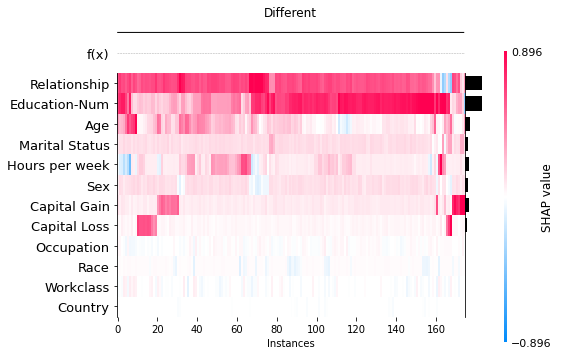

In [24]:
plot.shap_heatmap(shap_values_diff[is_normal & (pred_a != pred_b)], 'Different', feature_order)

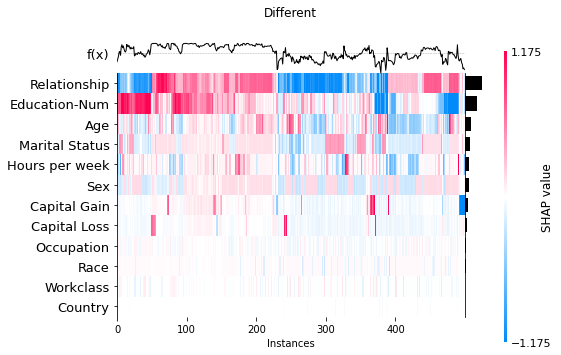

In [26]:
idx = shuffle(indices[is_normal & (pred_a == pred_b)], random_state=0, n_samples=500)
plot.shap_heatmap(shap_values_diff[idx], 'Different', feature_order)

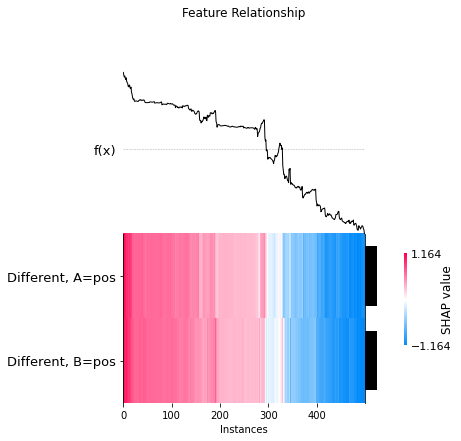

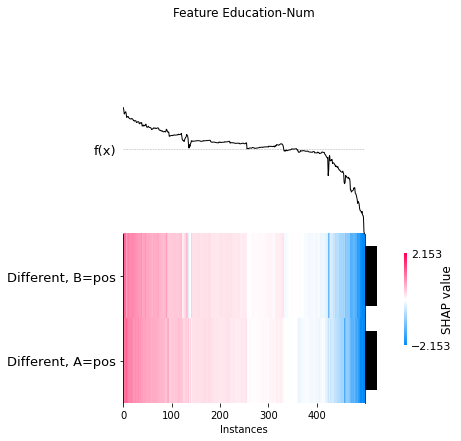

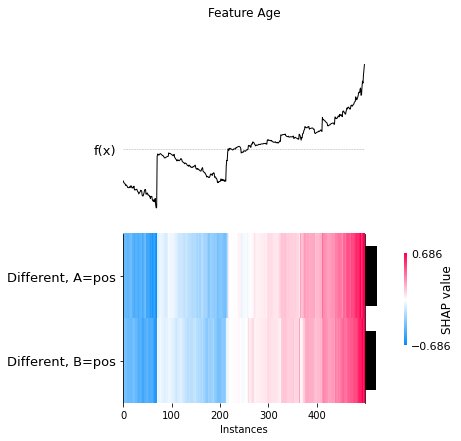

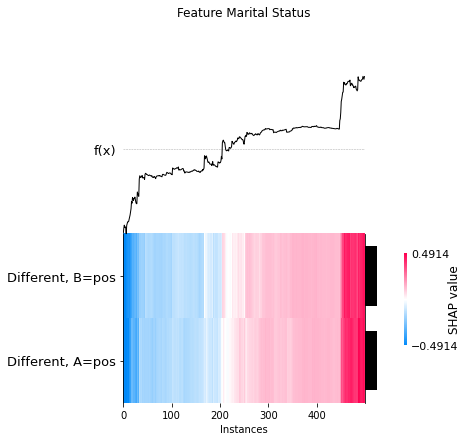

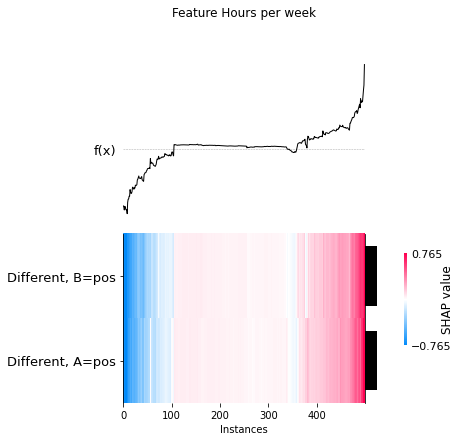

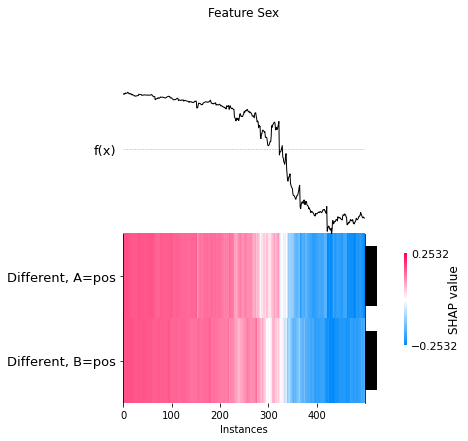

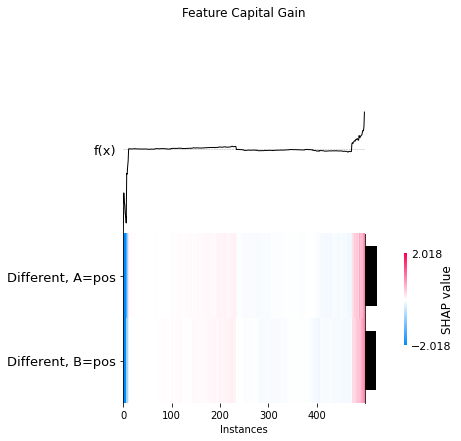

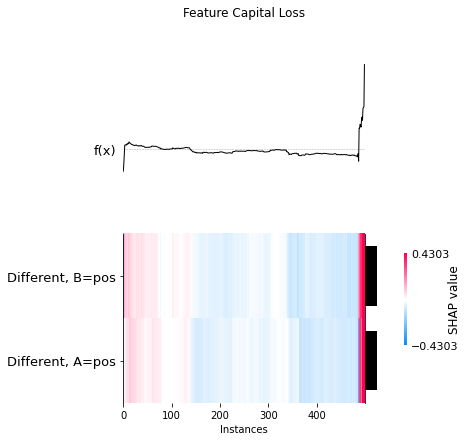

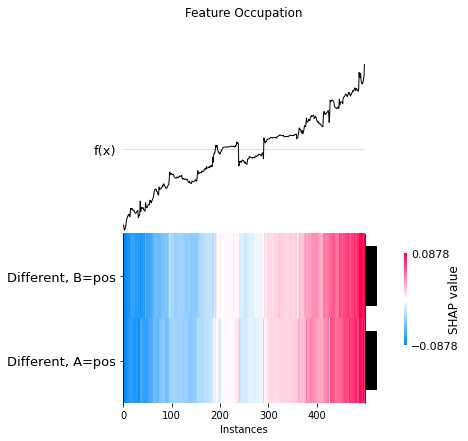

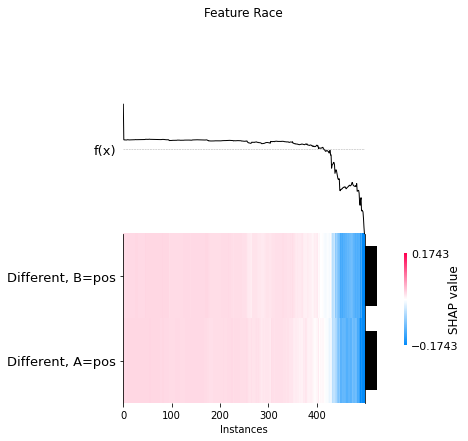

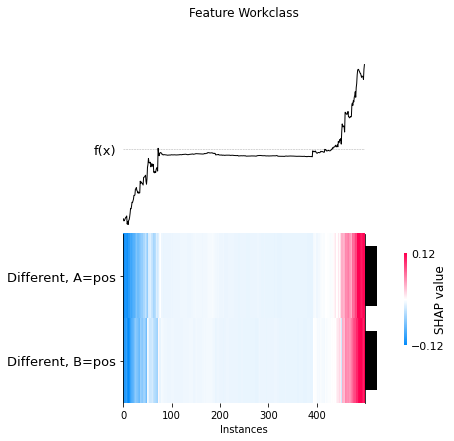

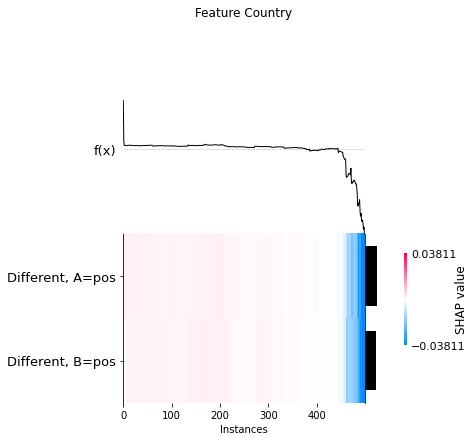

In [27]:
idx = shuffle(indices[is_normal], random_state=0, n_samples=500)
for feature in feature_names[feature_order]:
    a_feature = shap_values_diff_a_pos[idx, feature]
    b_feature = shap_values_diff_b_pos[idx, feature]
    values = np.array([a_feature.values, b_feature.values]).T
    base_values = np.array([a_feature.base_values, b_feature.base_values]).T
    data = np.array([a_feature.data, b_feature.data]).T
    dspl_data = np.array([a_feature.display_data, b_feature.display_data]).T
    explanation = shap.Explanation(values, base_values, data, dspl_data, feature_names=['Different, A=pos', 'Different, B=pos'])
    plot.shap_heatmap(explanation, 'Feature ' + feature)

### Unusual instances

#### Outliers in SHAP-values

An unusually high capital gain leads to a very big SHAP value for the instance's feature.

In [14]:
idx_outliers = np.where(is_outlier & is_finite)[0]

In [15]:
pd.DataFrame(display_data[idx_outliers, :], index=idx_outliers, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
1246,54.0,Self-emp-inc,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States
1368,52.0,Private,9.0,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,99999.0,0.0,40.0,Japan
1482,53.0,Self-emp-inc,9.0,Married-civ-spouse,Sales,Husband,White,Male,99999.0,0.0,40.0,United-States
1528,52.0,Private,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,50.0,United-States
1616,46.0,Private,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
31828,47.0,Private,14.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,55.0,United-States
31972,43.0,Self-emp-inc,15.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,40.0,United-States
32090,66.0,Private,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,55.0,?
32238,47.0,Private,15.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,40.0,United-States


In [19]:
for idx in shuffle(idx_outliers, n_samples=3):
    plot.shap_force(shap_values_diff[idx], f'Different (#{idx})')

#### Non-finite SHAP-values

~The `NaN` shap values in Workclass and Relationship seem to be connected to the unusually high capital gain~

In [20]:
idx_nonfinite = np.where(~is_finite)[0]

In [21]:
pd.DataFrame(display_data[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
6524,49.0,Self-emp-inc,14.0,Divorced,Prof-specialty,Unmarried,White,Male,99999.0,0.0,80.0,Mexico


In [23]:
pd.DataFrame(shap_values_diff[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
6524,-0.139238,0.014955,NaN,-0.158073,-0.008928,0.249963,-0.012612,-0.008996,-29.288962,0.074784,NaN,0.013012
